## <a id='1'>1. Import Libraries</a>

In [ ]:
!pip install selenium
!pip install tweepy
!pip install wordcloud
!pip install textblob
!pip install tweet-preprocessor

     |████████████████████████████████| 911kB 9.4MB/s 


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob

import preprocessor as p

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Data

In [ ]:
tweets=pd.read_excel('tweets_T2.xlsx')
tweets_df=pd.DataFrame(tweets)

## <a id='3'>3. Text Pre-processing</a> 
### <a id='3A'>A. Pre-processing 'Key Words'</a>
#### <a id='3Aa'>a. Removing '@names'</a>
Here we can see that at many places we have '@names', which is of no use, since it don't have any meaning, So needs to be removed.

In [ ]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
        text = p(text)
    return text

In [ ]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweet'], "@[\w]*: | *RT*")
tweets_df['tidy_tweets'].head(10)

Seems good, now we don't have '@name' values

#### <a id='3Ab'>b. Removing links (http | https)</a>

In [ ]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

#### <a id='3Ac'>c. Removing tweets with empty text</a>

In [ ]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

Unnamed: 0                   id  ...  textblob score vader score
0         948  1335753794647290112  ...        0.215152       0.399
1         949  1335747640839994880  ...        0.133333       0.347
2         950  1335736901974647040  ...        0.000000       0.423
3         951  1335630087488557056  ...        0.296591       0.309
4         952  1335617862333952000  ...        0.000000       0.000

[5 rows x 42 columns]

#### <a id='3Ad'>d. Dropping duplicate rows</a>

In [ ]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

Unnamed: 0                   id  ...  textblob score vader score
0         948  1335753794647290112  ...        0.215152       0.399
1         949  1335747640839994880  ...        0.133333       0.347
2         950  1335736901974647040  ...        0.000000       0.423
3         951  1335630087488557056  ...        0.296591       0.309
4         952  1335617862333952000  ...        0.000000       0.000

[5 rows x 42 columns]

#### <a id='3Ae'>e. Resetting index</a>
It seems that our index needs to be reset, since after removal of some rows, some index values are missing, which may cause problem in future operations.

In [ ]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

Unnamed: 0                   id  ...  textblob score vader score
0         948  1335753794647290112  ...        0.215152       0.399
1         949  1335747640839994880  ...        0.133333       0.347
2         950  1335736901974647040  ...        0.000000       0.423
3         951  1335630087488557056  ...        0.296591       0.309
4         952  1335617862333952000  ...        0.000000       0.000

[5 rows x 42 columns]

#### <a id='3Af'>f. Removing Punctuations, Numbers and Special characters</a>
This step should not be followed if we also want to do sentiment analysis on __key phrases__ as well, because semantic meaning in a sentence needs to be present. So here we will create one additional column 'absolute_tidy_tweets' which will contain absolute tidy words which can be further used for sentiment analysis on __key words__.

In [ ]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

#### <a id='3Ag'>g. Removing Stop words</a>
With the same reason we mentioned above, we won't perform this on 'tidy_tweets' column, because it needs to be used for __key_phrases__ sentiment analysis.

In [ ]:
stopwords_set = set(stopwords)
stopwords_set.add("like")
stopwords_set.add("amp")
stopwords_set.add("dont")
stopwords_set.add("know")
stopwords_set.add("time")
stopwords_set.add("im")
stopwords_set.add("good")
stopwords_set.add("day")
stopwords_set.add("know")
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))

tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

Unnamed: 0                   id  ...  textblob score vader score
0         948  1335753794647290112  ...        0.215152       0.399
1         949  1335747640839994880  ...        0.133333       0.347
2         950  1335736901974647040  ...        0.000000       0.423
3         951  1335630087488557056  ...        0.296591       0.309
4         952  1335617862333952000  ...        0.000000       0.000
5         953  1335244970949660928  ...        0.000000       0.316
6         954  1334896279248228096  ...        0.166667       0.124
7         955  1334713833802191104  ...        0.750000       0.630
8         956  1334650673577615104  ...        0.000000       0.403
9         957  1334521285485809920  ...        0.100000       0.000

[10 rows x 42 columns]

#### <a id='3Ah'>h. Tokenize *'absolute_tidy_tweets'*</a>  

In [ ]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                                   []
1                   [CheeseburgerOH, Selflove, finest]
2                                       [Monday, mood]
3    [CheeseburgerOH, wEzfpAtbfOqe, What, I, unleas...
4    [Crazy, mofos, I, surround, Weird, ppl, weird,...
Name: absolute_tidy_tweets, dtype: object

#### <a id='3Ai'>i. Converting words to Lemma</a>

In [ ]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                                                   []
1                   [CheeseburgerOH, Selflove, finest]
2                                       [Monday, mood]
3    [CheeseburgerOH, wEzfpAtbfOqe, What, I, unleas...
4    [Crazy, mofos, I, surround, Weird, ppl, weird,...
Name: absolute_tidy_tweets, dtype: object

#### <a id='3Aj'>j. Joining all tokens into sentences</a>

In [ ]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

id  ...                               absolute_tidy_tweets
0  1343849645521338369  ...                                                   
1  1343496082639077376  ...                     CheeseburgerOH Selflove finest
2  1343472220341850112  ...                                        Monday mood
3  1343472023805198337  ...       CheeseburgerOH wEzfpAtbfOqe What I unleashed
4  1343151046483275777  ...  Crazy mofos I surround Weird ppl weird ppl lif...
5  1343135985001873419  ...  Kinda upset I havent seen Drunk Darren While h...
6  1343119111912521729  ...           SenyoritoJDL Sending virtual hug brother
7  1343092205880180737  ...                                               Love
8  1343085637893701634  ...                   Fancy Darren Darren Ive yet meet
9  1343083717632278528  ...    wEzfpAtbfOqe AHOOMEE He drink everyones portion

[10 rows x 38 columns]

### <a id='3B'>B. Pre-processing 'Key Phrases'</a> 

#### <a id='3Ba'>a. Helper class, will help in preprocessing phrase terms</a>

In [ ]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

#### <a id='3Bb'>b. Grammatical rule to identify phrases</a>

In [ ]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

#### <a id='3Bc'>c. New feature called 'key_phrases', will contain phrases for corresponding tweet</a>

In [ ]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
tweets_df['key_phrases'] = key_phrases
tweets_df.head()

id  ...                                        key_phrases
0  1343849645521338369  ...                                                 []
1  1343496082639077376  ...                         [cheeseburgeroh self-love]
2  1343472220341850112  ...                                      [monday mood]
3  1343472023805198337  ...                              [cheeseburgeroh  @we]
4  1343151046483275777  ...  [crazy mofos, weird ppl, weird ppl life, regre...

[5 rows x 39 columns]

# Analysis

In [ ]:
tweets_df.head()

Unnamed: 0                   id  ...  textblob score vader score
0         948  1335753794647290112  ...        0.215152       0.399
1         949  1335747640839994880  ...        0.133333       0.347
2         950  1335736901974647040  ...        0.000000       0.423
3         951  1335630087488557056  ...        0.296591       0.309
4         952  1335617862333952000  ...        0.000000       0.000

[5 rows x 42 columns]

In [ ]:
def textblob_score(row):
  return TextBlob(row['absolute_tidy_tweets']).sentiment.polarity

def vader_score(row):
  analyser = SentimentIntensityAnalyzer()
  score = analyser.polarity_scores(row['absolute_tidy_tweets'])
  choosen = max(score)
  if choosen == 'pos':
    result = score[max(score)]
  elif choosen == 'neg':
    result = -score[max(score)]
  else:
    result = 0
  return result

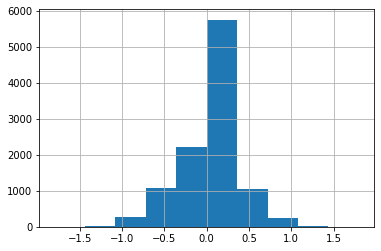

In [ ]:
tweets_df['textblob score'] = tweets_df.apply (lambda row: textblob_score(row), axis=1)
plt.figure()
tweets_df["textblob score"].diff().hist()

In [ ]:
tweets_df['vader score'] = tweets_df.apply (lambda row: vader_score(row), axis=1)
plt.figure()
tweets_df["vader score"].diff().hist()

In [ ]:
tweets_df.to_excel(r'AlexisLeeXY.xlsx', index = False)

In [ ]:
tweets=pd.read_excel('tweets_T1.xlsx')
tweets_df=pd.DataFrame(tweets)

In [ ]:
tweets_df['textblob_score'] = tweets_df['textblob score'] 
tweets_df.shape

(948, 43)

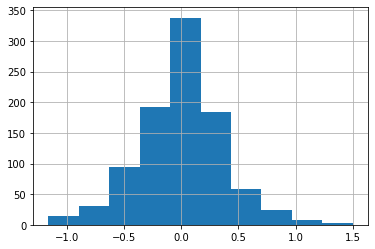

In [ ]:
# tweets_df['textblob_score'] = tweets_df.apply (lambda row: textblob_score(row), axis=1)
# plt.figure()
tweets_df["textblob_score"].diff().hist()